<a href="https://colab.research.google.com/github/JannatL/Quiz3_Wine/blob/main/J_Lily_Quiz3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quiz 3: Cleaning Wine Data

####by Jannat Lily

##**Introduction**
  This dataset contains information on 12,795 different wines relating to their chemical composition, marketing features, expert rating on their qaulity, and their sales results.

  We will analyze the wine features to understand sales behavior. We clean up the data so that it can be used to can build a model that predicts the **Target** variable, which is the number of cases of wine sold.

  In our dataset, **Index**, refers to the unique ID of each wine sample and can be disregarded from the analysis. **Acid Index, Alcohol, Chorides, Citric Acid, Density, Fixed Acidity, Free Sulfur Dioxide, pH, Redidual Sugar, Sulphates, and Volatile Acidity** are all attributes that refer to the chemical properties of the wine. They are used to quantify the wine's flavor in a way that allows us to study how flavor affects sales trends.

  **Label Appeal** is a score of how visually appealing the wine is. **STARS** is an expert rating of the wine that ranges from 1 (poor) to 4 (excellent) quality.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style="whitegrid")

#load data
url = "https://raw.githubusercontent.com/JannatL/Quiz3_Wine/main/Day2_Data.csv"
df = pd.read_csv(url)

#preview the data
print(df.shape)
df.head()


(12795, 16)


,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,1,3,3.20,1.16,-0.98,54.20,-0.57,NaN,268.00,0.99,3.33,-0.59,9.90,0,8,2.00
1,2,3,4.50,0.16,-0.81,26.10,-0.42,15.00,-327.00,1.03,3.38,0.70,NaN,-1,7,3.00
2,4,5,7.10,2.64,-0.88,14.80,0.04,214.00,142.00,1.00,3.12,0.48,22.00,-1,8,3.00
3,5,3,5.70,0.39,0.04,18.80,-0.42,22.00,115.00,1.00,2.24,1.83,6.20,-1,6,1.00
4,6,4,8.00,0.33,-1.26,9.40,NaN,-167.00,108.00,0.99,3.12,1.77,13.70,0,9,2.00


##**Exploratory Data Analysis**

###Check for Duplicate rows and Missing Data:

In [7]:
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

# Check for missing values
missing_vals = df.isnull().sum()
missing_percent = (missing_vals / len(df)) * 100
print("\nMissing Value Summary:")
print(pd.DataFrame({"Missing Count": missing_vals, "Percent": missing_percent.round(2)}))

Duplicate rows: 0

Missing Value Summary:
                    Missing Count  Percent
INDEX                           0     0.00
TARGET                          0     0.00
FixedAcidity                    0     0.00
VolatileAcidity                 0     0.00
CitricAcid                      0     0.00
ResidualSugar                 616     4.81
Chlorides                     638     4.99
FreeSulfurDioxide             647     5.06
TotalSulfurDioxide            682     5.33
Density                         0     0.00
pH                            395     3.09
Sulphates                    1210     9.46
Alcohol                       653     5.10
LabelAppeal                     0     0.00
AcidIndex                       0     0.00
STARS                        3359    26.25


There are no duplicate rows, but there are missing values under several attributes. STARS will need to be imputed to better predecit sales.

###Check for Incorrect Data
Certain attributes, such as pH rating, should not have negative values.

In [8]:
#Check for negative values in appropriate cols
chemistry_cols = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'ResidualSugar',
                  'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
                  'pH', 'Sulphates', 'Alcohol']
invalids = df[chemistry_cols] < 0
invalid_summary = invalids.sum()
invalid_summary[invalid_summary > 0]


,0
FixedAcidity,1621
VolatileAcidity,2827
CitricAcid,2966
ResidualSugar,3136
Chlorides,3197
FreeSulfurDioxide,3036
TotalSulfurDioxide,2504
Sulphates,2361
Alcohol,118


We will replace these negative vlaues with NaN because in the context of chemistry, they make no sense.

###Histograms for Numeric Features

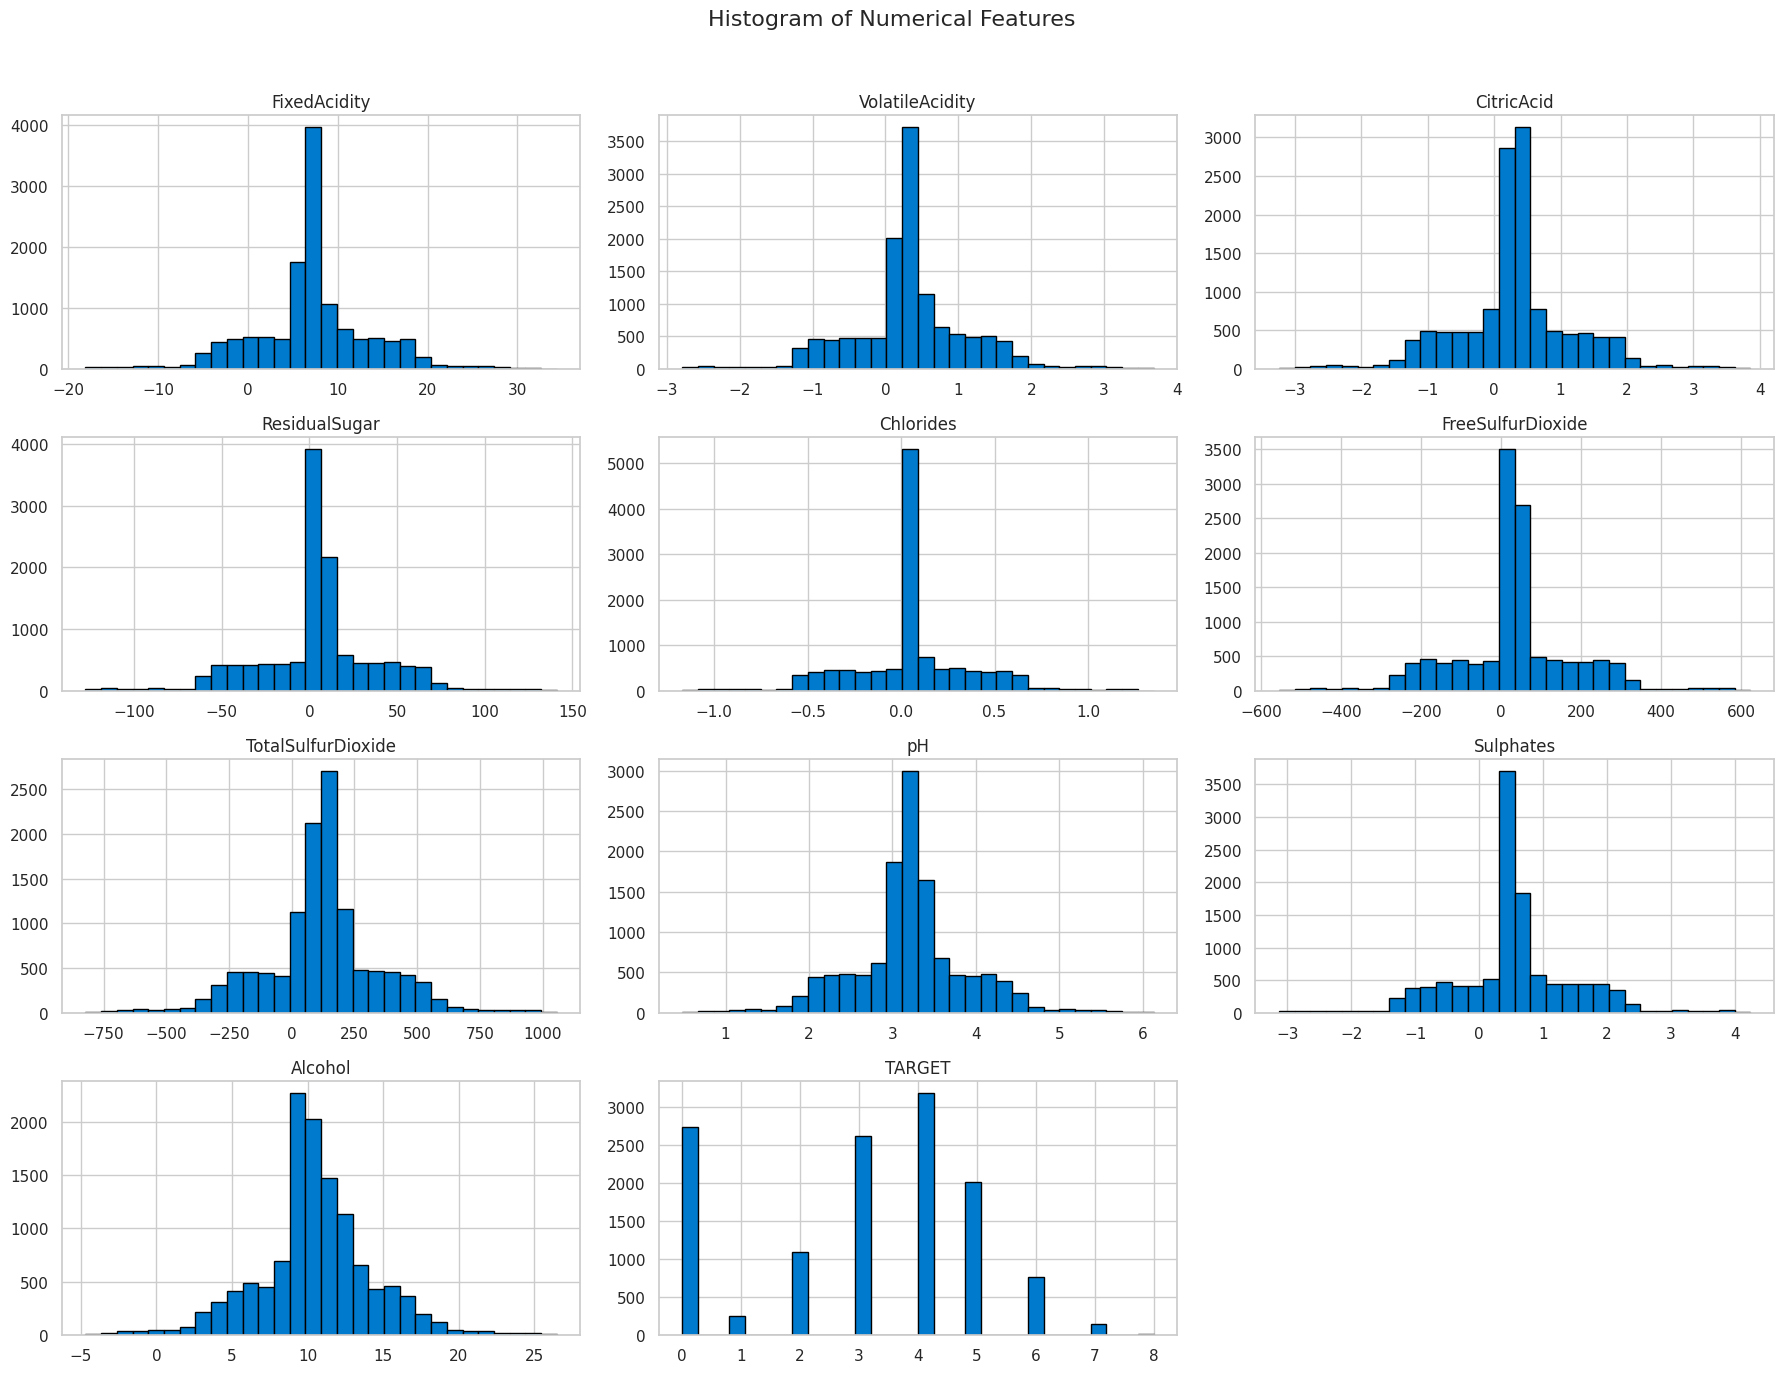

In [9]:
import matplotlib.pyplot as plt

df[chemistry_cols + ['TARGET']].hist(bins=30, figsize=(18, 14), color='#007acc', edgecolor='black')
plt.suptitle('Histogram of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- ResidualSugar, Sulphates, and TotalSulfurDioxide are all right skewed, which could negatively affect the algorithm during modeling. To fix this issue, we can use log transformation.
- Alcohol, CitricAcid, and FixedAcidity also have a mild skew.
- Target is skewed but it should be that way to reflect the sales data.

###Boxplots to find Outliers

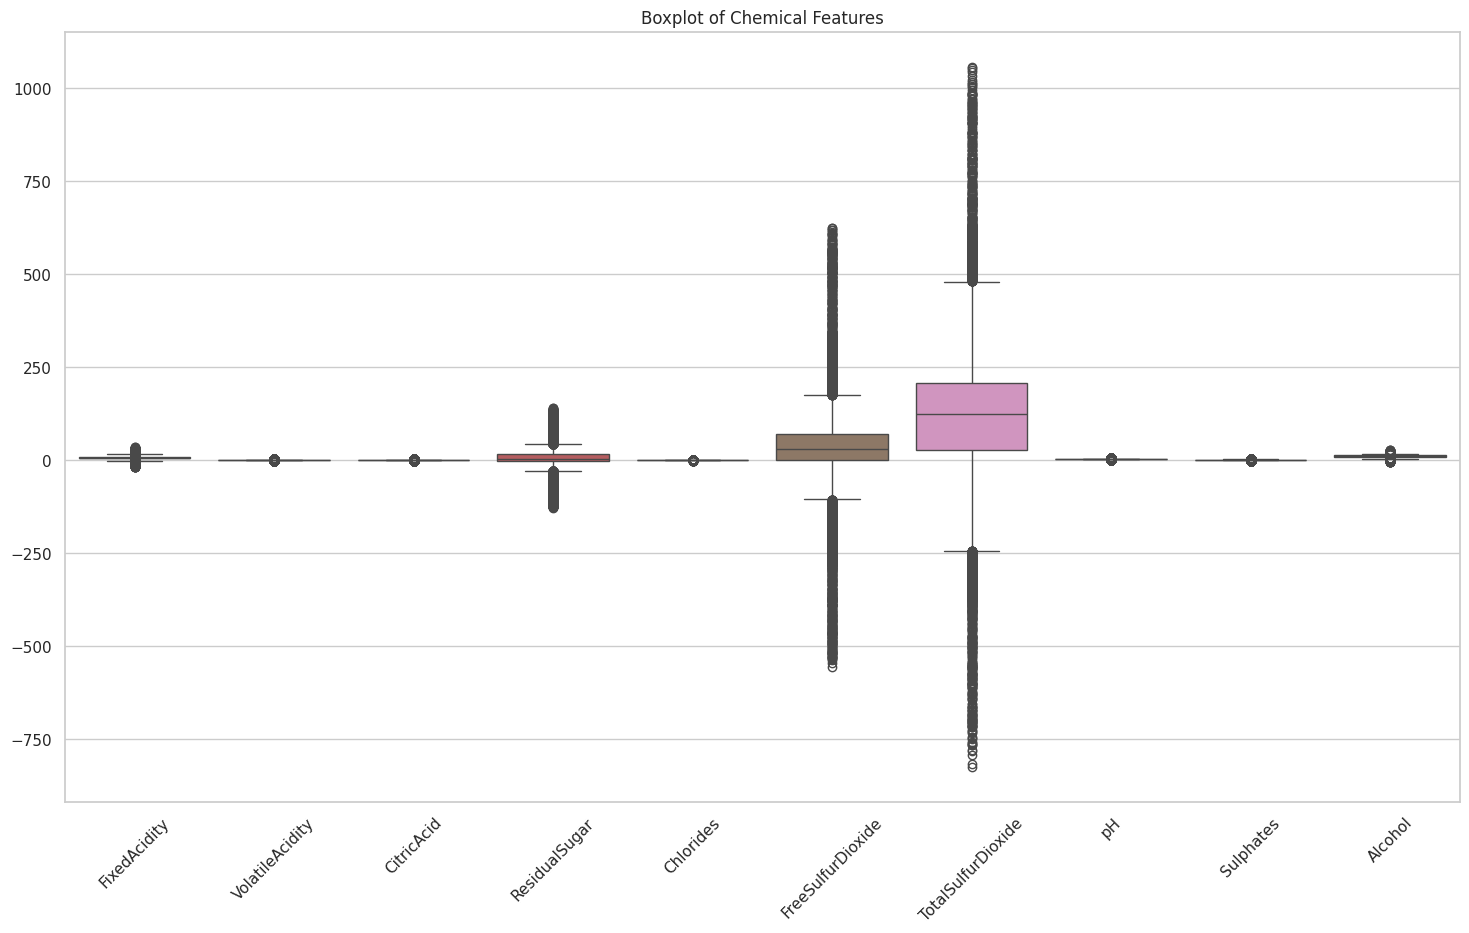

In [10]:
plt.figure(figsize=(18, 10))
sns.boxplot(data=df[chemistry_cols])
plt.xticks(rotation=45)
plt.title('Boxplot of Chemical Features')
plt.show()


- There are extreme values in ResidualSugar and FreeSulfurDioxide
- There are also negative values in Alcohol that need to be addressed
- The outliers need to be cleaned so that they don't distort statistics like mean and standard deviation

###Heat Map

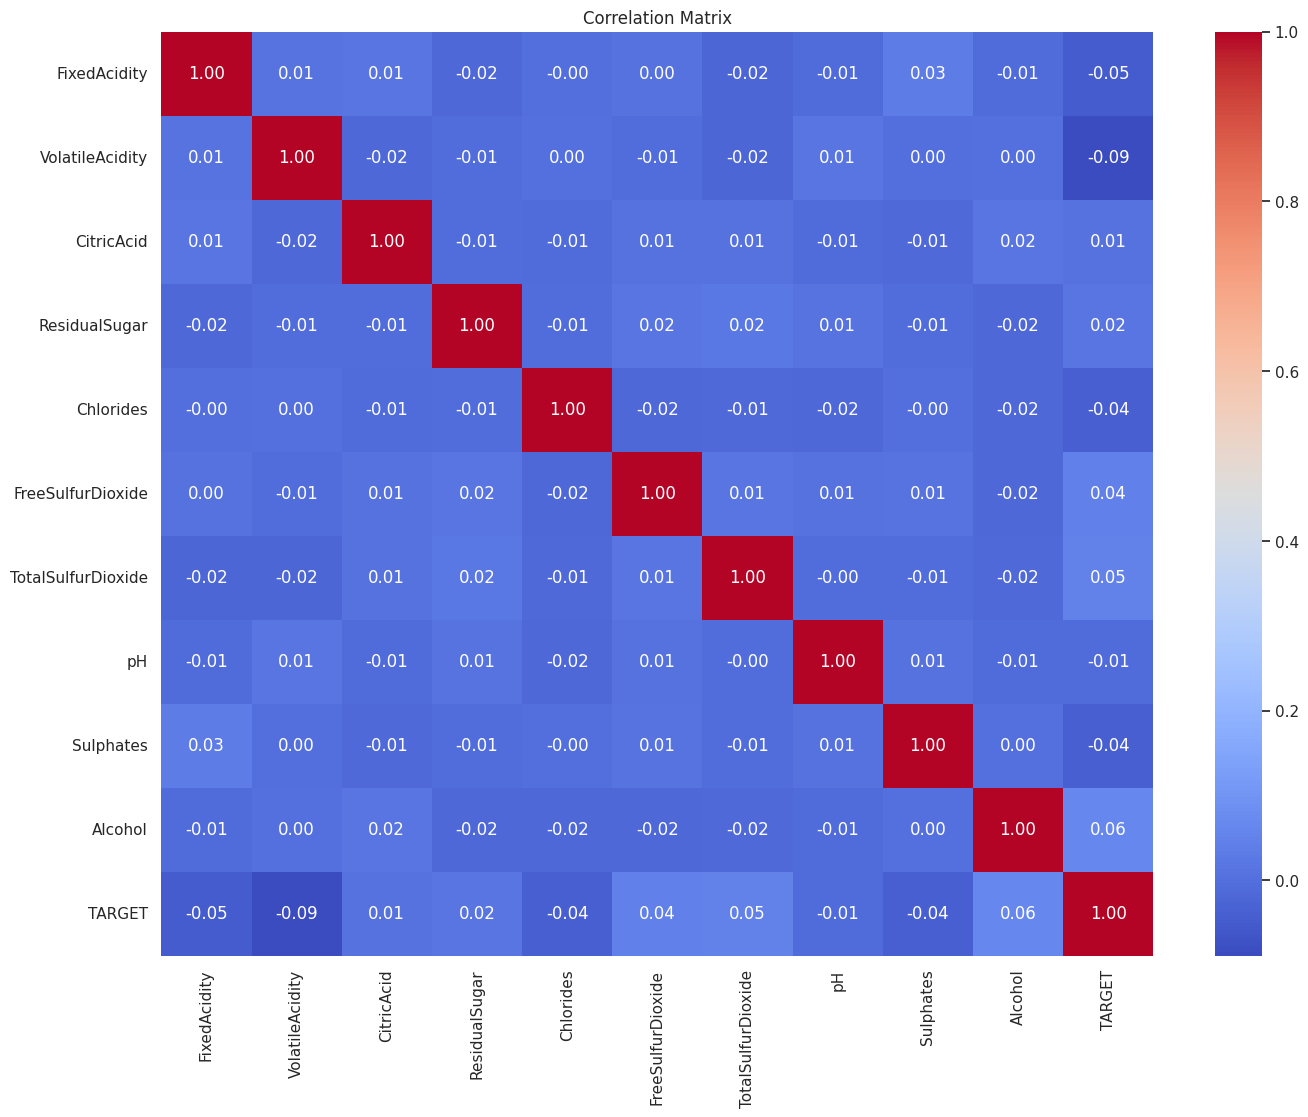

In [11]:
plt.figure(figsize=(16, 12))
sns.heatmap(df[chemistry_cols + ['TARGET']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


- FreeSulfurDioxide and TotalSulfurDioxide are correlated, which is expected
- LabelAppeal is positively correlated with TARGET

- STARS also correlates with TARGET

###Comparing LabelAppeal vs TARGET

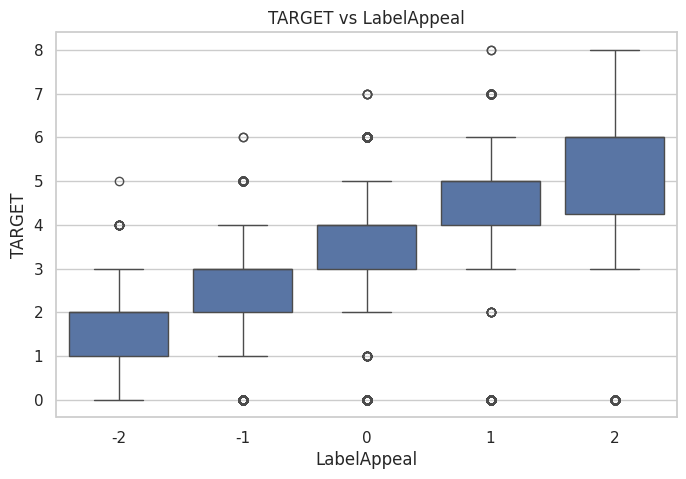

In [12]:
# LabelAppeal vs TARGET
plt.figure(figsize=(8, 5))
sns.boxplot(x='LabelAppeal', y='TARGET', data=df)
plt.title("TARGET vs LabelAppeal")
plt.show()

- We use a boxplot because LabelAppeal is an ordinal variable.
- Wines with better LabelAppeal have better target sales values, which makes LabelAppeals a feature that will be reliable in helping to predict sales.

###Comparing STARS vs TARGET

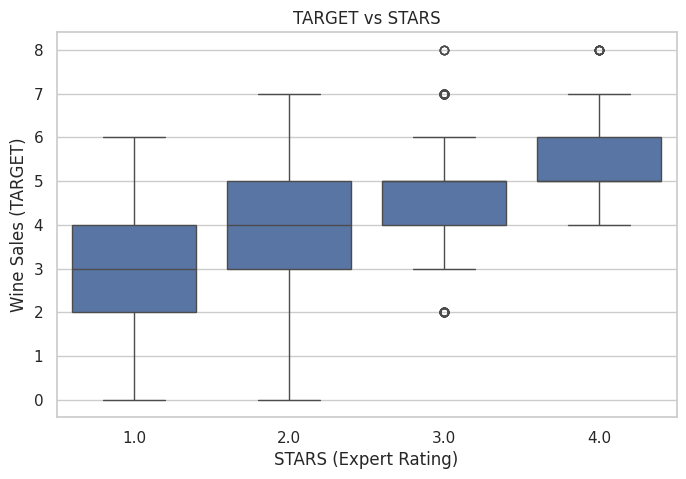

In [13]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='STARS', y='TARGET', data=df)
plt.title("TARGET vs STARS")
plt.xlabel("STARS (Expert Rating)")
plt.ylabel("Wine Sales (TARGET)")
plt.show()


- As stars increase (1 to 4), median sales also increase, showing a positive correlation.
- It could potentially be used to predict target sales, however we must consider the fact that the popularity of a wine (due to high sales) may affect brand name recognition and introduce expert bias into the star rating system.
- For this reason, we should omit this attritube from our model to create less biased predictions.

Our EDA has shown the presence of invalid values in pH, ResidualSugar, Sulphates, and sulfur dioxide levels that are physically impossible and must be corrected. We also discovered missing values in STARS that should be imputed.

ResidualSugar, Sulphates, and sulfur dioxide compounds all have skewed distributions that can negatively impact many machine learning algorithms. Transformations like logarithmic scaling will be used to normalize these features. Outliers will also be handled.

Finally, we will use LabelAppeal, and not STARS, to predict TARGET values without as much bias.



##**Data Preperation**

###Removing Invalid Values
Negative values in the attributes that measure chemical properties do no make sense. For example, pH values must range from 0 to 14 and it is not possible to have a negative quantity of the other ingredients.

They must be replaced with NaN so that they can be imputed.  

In [14]:
#Create copy to preserve original data
clean_df = df.copy()

#List of chemical features that can't be negative
chemistry_cols = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'ResidualSugar',
                  'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
                  'pH', 'Sulphates', 'Alcohol']

#Replace negatives with NaN
for col in chemistry_cols:
    clean_df[col] = clean_df[col].apply(lambda x: np.nan if x < 0 else x)


###Impution of Invalid Values
Features like ResidualSugar, Sulphates, and FreeSulfurDioxide are highly skewed or have outliers, which means that their mean values are not a relaible measure of central tendency. Therefore instead of mean, we will use the median value of each attribute to impute the missing values. This would help prevent distortion of our data.

In [17]:
#Impute with median
for col in chemistry_cols:
    clean_df[col] = clean_df[col].fillna(clean_df[col].median())


###Impution of Missing Values in STAR
STAR is an ordinal categorical feature, which means that its missing values can't be inferred with mathematical operations like mean or mode. We could potentially use predictive models like regression, but in this case that would introduce too many assumptions that could overfit the data.

Therefor, the safest way to impute the STAR attribute would be using mode. We can assume that a brand that has a lot of 3 or 2 star ratings will have more of the same. This allows us to impute and use the data while maintaining its integrity.

In [16]:
#Impute STARS with mode
clean_df['STARS'] = clean_df['STARS'].fillna(clean_df['STARS'].mode()[0])

###Log Transformation on Skewed Data
The attributes with high right skews and outliers can negatively affect the model by giving too much weight to the more extreme values. This can be fixed by using Log Transformation, which compresses high values and expands low ones, making the distribution more symmetric.

We use log1p() to safely handle values near zero.

In [18]:
#Reduce skewness
log_transform_cols = ['ResidualSugar', 'Sulphates', 'Alcohol', 'FreeSulfurDioxide', 'TotalSulfurDioxide']

for col in log_transform_cols:
    clean_df[col + '_log'] = np.log1p(clean_df[col])  # log1p(x) = log(1 + x)


###Feature Scaling
Our dataset has chemical features that vary widely in scale. This variety can cause our model to incorrectly favor large value features, like sulfur, over small scale features, like pH.

To fix this, we can use feature scaling with StandardScaler() that will ensure that all features have a mean of 0 and standard deviation of 1. Therefore all features would contribute equally to the model.

In [20]:
from sklearn.preprocessing import StandardScaler

#Standardize original (not log) features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clean_df[chemistry_cols])
scaled_df = pd.DataFrame(scaled_data, columns=[col + '_scaled' for col in chemistry_cols])

#Add back into main DataFrame
clean_df = pd.concat([clean_df, scaled_df], axis=1)


##**Prepped Data Review**

###Histograms for Improved Numeric Features:


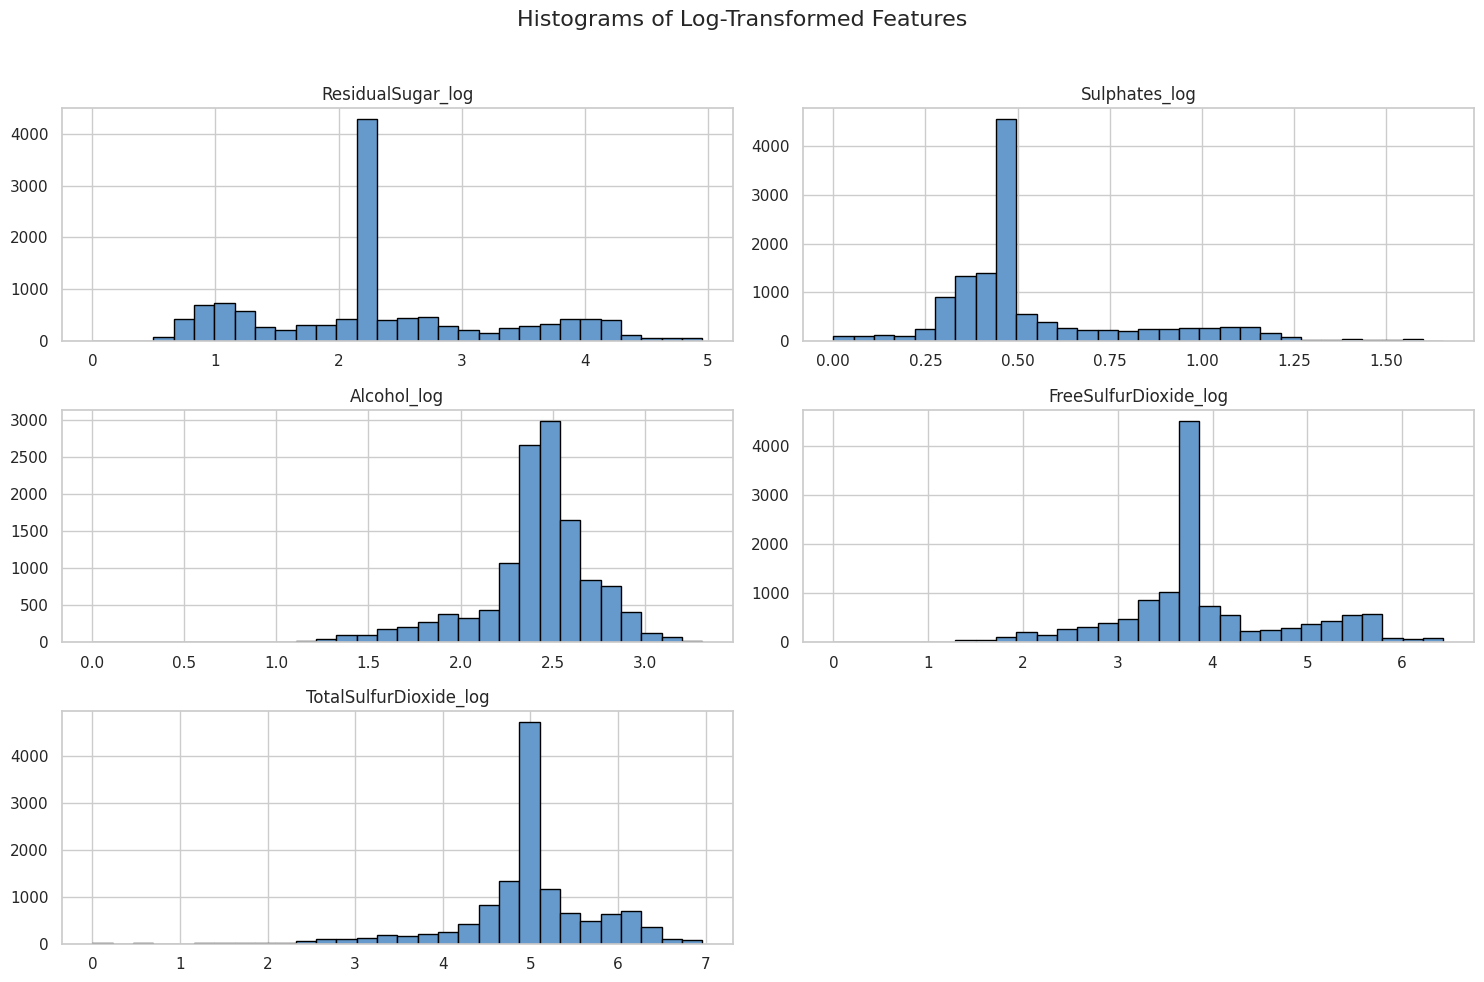

In [21]:
#Histograms on new data
log_cols = ['ResidualSugar_log', 'Sulphates_log', 'Alcohol_log', 'FreeSulfurDioxide_log', 'TotalSulfurDioxide_log']
clean_df[log_cols].hist(bins=30, figsize=(15, 10), color='#6699cc', edgecolor='black')
plt.suptitle('Histograms of Log-Transformed Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- These histograms show the revelent numeric features after Log Transformation was done on them.
- ResidualSugar previously had a long right tail, but now is more symetric with the histogram ranging from 0-5
- Similar results can be seen with Sulphates, FreeSulfurDioxide, TotalSulfurDioxide, and Alcohol
- Negative values no longer exist on these graphs

###Boxplots for Scaled Features

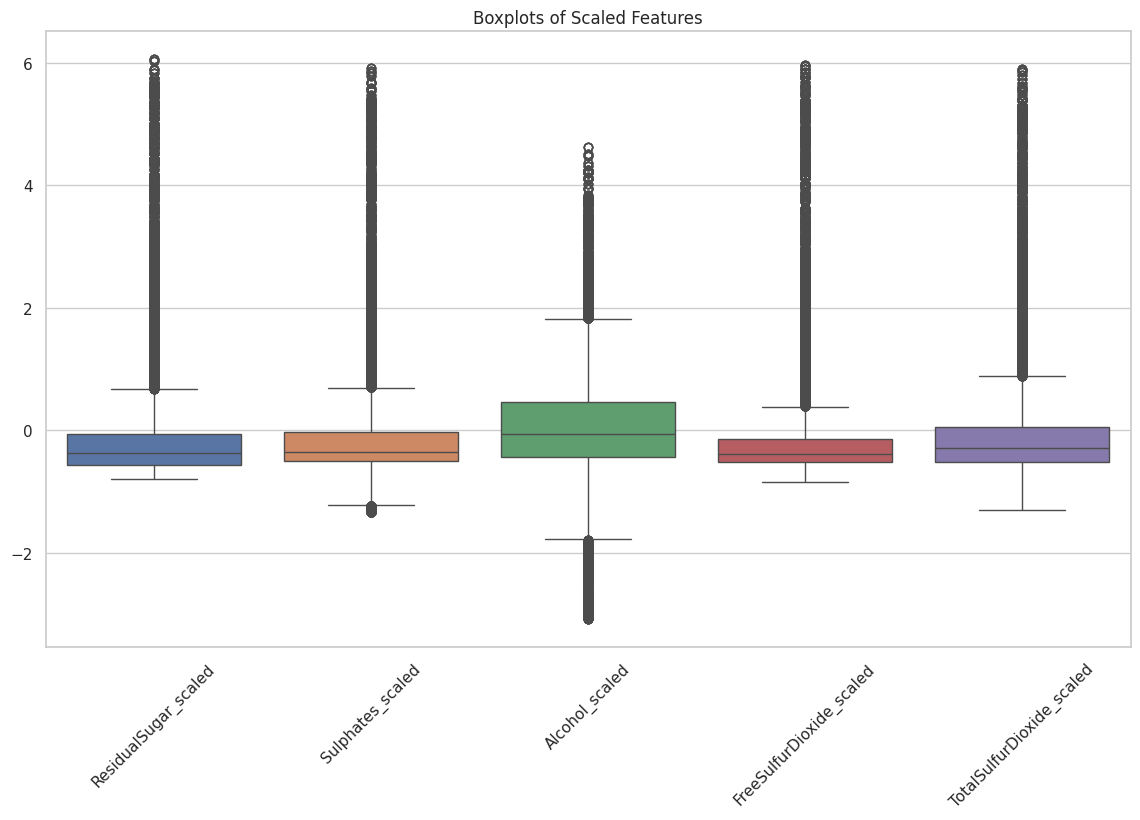

In [22]:
scaled_cols = [col + '_scaled' for col in ['ResidualSugar', 'Sulphates', 'Alcohol', 'FreeSulfurDioxide', 'TotalSulfurDioxide']]
plt.figure(figsize=(14, 8))
sns.boxplot(data=clean_df[scaled_cols])
plt.xticks(rotation=45)
plt.title('Boxplots of Scaled Features')
plt.show()


- These boxplots show scaled versions of each feature that we used StandardScaler() on.
- They show that we have successfully brought all features to a similar range, centered around 0.
- Some outliers still exist but this may be a normal reflection of the real world variation in wines.

###Heat Map of Cleaned Data

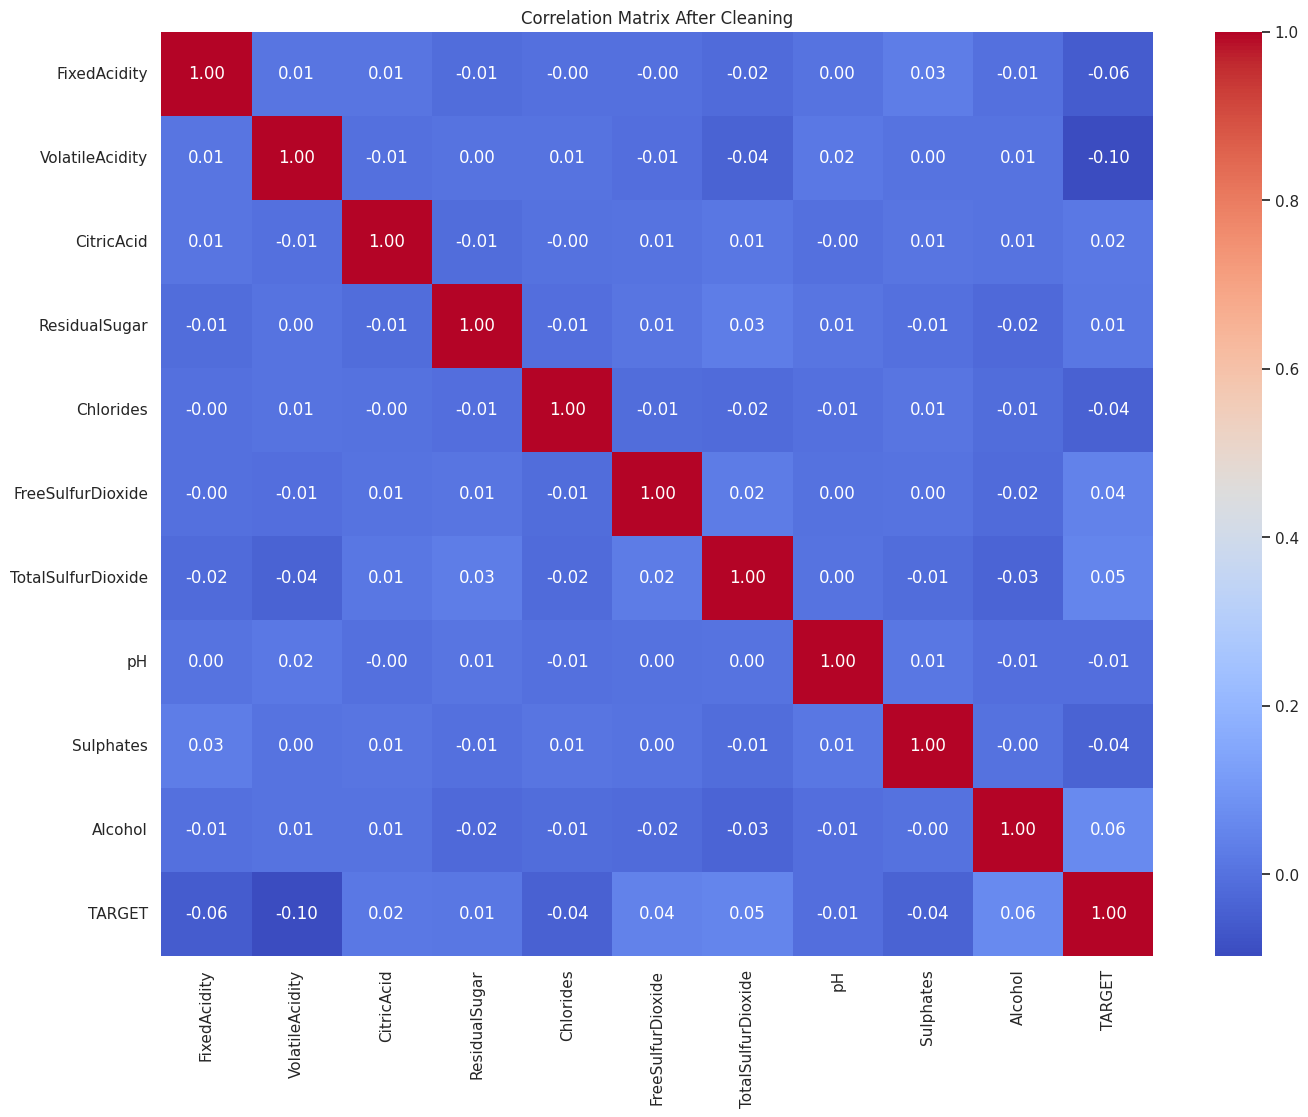

In [23]:
plt.figure(figsize=(16, 12))
sns.heatmap(clean_df[chemistry_cols + ['TARGET']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix After Cleaning")
plt.show()


- LabelValue and STARS are still positively correlated to TARGET, which means that LabelValue can still be used to help predict target values and that our impution of STAR values did not ruin the data.
- The map also shows that no other new correlations were introduced in our data preperation stage, which is good. It indicates that we were able to clean the data without making too many false assumptions.

###Check for Missing or Invalid Values

In [25]:
#Check for missing values
missing_summary = clean_df.isnull().sum()

#Check for remaining negative values in chemical features
negative_summary = clean_df[chemistry_cols].apply(lambda x: (x < 0).sum())

#Print results
print("Missing values per column:")
print(missing_summary[missing_summary > 0])

print("\nNegative values per column (should all be 0):")
print(negative_summary[negative_summary > 0])


Missing values per column:
Series([], dtype: int64)

Negative values per column (should all be 0):
Series([], dtype: int64)


- Our results show that there are no longer any missing values in the data
- The chemical attributes no longer contain any negative values

##**Summary**

  This dataset, which contains information on 12,795 wine samples and their expert ratings, chemical contents, and label appeal, has been cleaned and can now be used to train models that will predict TARGET values.

  The EDA showed that many features had missing or invalid data values. These values were identified and labled as NaA in the Data Preperation step. Some values were imputed using the median central tendency and STAR was imputed using mode. The results show that no missing or invalid values remain, but the dataset retains intergrity in correlation and other graphs. This indicates that impution was successful and instead of dropping invalid or missing data, we can use the improved dataset to create more accurate modeling.

  The EDA also showed that some features had a high right skew. These features were successfully log transformed, as indicated with histograms. This means that the data will now be more effective and accurate in modeling without distoring or slowing down the process.

  StandScaler was also performed for the purpose of normalizing features. After scaling, outliers still exist in our data but they aren't as extreme and they won't distrupt modeling as much.

  After these changes, the dataset is ready to be used predict wine sales in the future.

